In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# this is the size of the sliding window: the data of N consecutive days will be used to predict the mood of the next day
N = 3

df = pd.read_csv('data/imputed_data_valence_activity.csv')
#df.drop(['datetime'], axis=1, inplace=True)
#df.drop(['id'], axis=1, inplace=True)

data_new = df.copy()

data_new['datetime'] = pd.to_datetime(data_new['datetime'])

# Ensure data is sorted as expected
data_new.sort_values(by=['id', 'datetime'], inplace=True)

# Function to filter for consecutive days
def filter_consecutive_days(group):
    # Calculate the difference between consecutive days
    group['diff_days'] = group['datetime'].diff().dt.days

    # Identify start of new consecutive sequence
    group['start_new_sequence'] = (group['diff_days'] != 1).cumsum()

    # Count days in each sequence
    group['sequence_count'] = group.groupby('start_new_sequence').cumcount() + 1

    # Filter sequences with at least n consecutive days
    valid_sequences = group[group['sequence_count'] >= N]['start_new_sequence'].unique()
    return group[group['start_new_sequence'].isin(valid_sequences)]

# Apply the function to each group
consecutive_data = data_new.groupby('id').apply(filter_consecutive_days, include_groups=False).reset_index(drop=False)

# Drop auxiliary columns used for calculation
consecutive_data.drop(columns=['diff_days', 'start_new_sequence', 'sequence_count', 'level_1'], inplace=True)

# Display the processed data
consecutive_data.head(), consecutive_data['datetime'].min(), consecutive_data['datetime'].max()

consecutive_data.to_csv('data_new.csv', index=False)

TypeError: filter_consecutive_days() got an unexpected keyword argument 'include_groups'

In [116]:
mean_cols = ['mood', 'circumplex.arousal',
       'circumplex.valence', 'activity']
sum_cols = ['screen', 'call', 'sms',
       'appCat_total', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather']

# Function to apply rolling window aggregation with correct mood_of_next_day handling
def sliding_window_aggregation_corrected(group):
    # Rolling window setup for means and sums
    rolled_means = group[mean_cols].rolling(window=N, min_periods=N).mean()
    rolled_sums = group[sum_cols].rolling(window=N, min_periods=N).sum()

    # Combine the results into the day N row
    combined = pd.concat([rolled_means, rolled_sums], axis=1)

    # The mood_of_next_day from day n's record
    combined['mood_of_next_day'] = group['mood_of_next_day']

    # We align this so that the aggregates and mood_of_next_day are all in the day N row
    return combined

# Apply the function to each group
sliding_window_data_corrected = (consecutive_data.groupby('id').apply(sliding_window_aggregation_corrected, 
                                                                      include_groups=False)
                                 .reset_index(level=0, drop=False))

# Drop rows where the window did not complete, which is the first N-1 days of each sequence
sliding_window_data_final = sliding_window_data_corrected.dropna().reset_index(drop=False)

sliding_window_data_final.drop(['index'], axis=1, inplace=True)
# Display the first few rows of the processed data
sliding_window_data_final.head()

sliding_window_data_final.to_csv('data_sliding_window.csv', index=False)


In [117]:
# Classification KNN
sliding_window_data_final_classification = sliding_window_data_final.copy()
# Preparing the target variable
# Categorizing mood_of_next_day
def categorize_mood(mood):
    if 1.0 <= mood <= 6.9999999:
        return 1  # Mood between 1 and 7
    elif 7.0 <= mood <= 7.9999999:
        return 2  # Mood between 7 and 8
    elif 8.0 <= mood <= 10.0:
        return 3  # Mood between 8 and 10
    else:
        return None  # In case there are values outside the expected range

# Apply the categorization function to the 'mood_of_next_day' column
# CAREFUL: RUN THIS ONLY ONCE, OTHERWISE IT WILL KEEP CATEGORIZING THE ALREADY CATEGORIZED VALUES
sliding_window_data_final_classification['mood_of_next_day'] = sliding_window_data_final_classification['mood_of_next_day'].apply(categorize_mood)

In [118]:
# Display the modified data to see the new categorization 
sliding_window_data_final_classification.head()

,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat_total,appCat.builtin,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,mood_of_next_day
0,1,6.466667,0.333333,0.500000,0.171224,30894.900001,9.0,1.0,31108.660,5156.893,...,114.023,0.0,172.206,410.717,5848.971,952.750,0.000,746.461,30.386,1
1,1,6.400000,0.533333,0.433333,0.152861,27963.344002,13.0,1.0,29237.289,2884.631,...,98.585,0.0,3.010,237.524,4564.097,457.110,0.000,326.439,30.386,1
2,1,6.516667,0.500000,0.433333,0.106692,43296.538001,10.0,1.0,36713.026,3185.970,...,120.563,0.0,3.010,318.200,6043.936,419.805,235.223,431.711,30.386,1
3,1,6.450000,0.366667,0.366667,0.092881,52946.507000,10.0,1.0,44859.560,3067.221,...,129.491,0.0,3.010,342.875,9735.156,419.805,235.223,434.990,0.000,2
4,1,6.783333,0.166667,0.633333,0.119731,55341.305999,2.0,2.0,40069.271,3429.592,...,137.604,0.0,182.451,334.849,7446.911,47.314,235.223,435.287,0.000,1


In [119]:
sliding_window_data_final_classification.drop('id', axis=1, inplace=True)

In [120]:
correlation = sliding_window_data_final_classification.corr()

correlation['mood_of_next_day'].sort_values(ascending=False)

mood_of_next_day        1.000000
mood                    0.396370
circumplex.valence      0.204028
appCat.entertainment    0.124417
activity                0.104209
appCat.other            0.097996
appCat.communication    0.097466
screen                  0.094735
appCat.game             0.092505
appCat_total            0.087736
appCat.utilities        0.058648
appCat.finance          0.057178
appCat.office           0.056403
appCat.unknown          0.048070
appCat.travel           0.030882
appCat.weather          0.026421
circumplex.arousal      0.010963
appCat.builtin         -0.005173
call                   -0.045527
appCat.social          -0.058012
sms                    -0.066189
Name: mood_of_next_day, dtype: float64

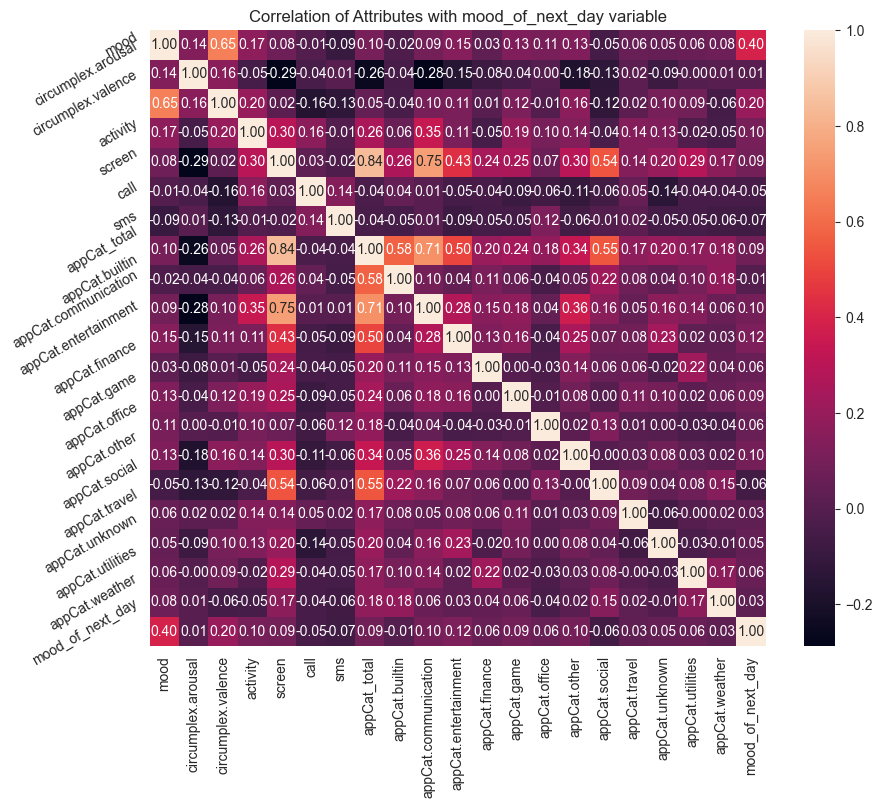

In [121]:
plt.figure(figsize=(10,8))
plt.title('Correlation of Attributes with mood_of_next_day variable')
a = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score


# Split the data into features (X) and target (y)
X = sliding_window_data_final_classification.drop('mood_of_next_day', axis=1)
y = sliding_window_data_final_classification['mood_of_next_day']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [123]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [124]:
y_pred = knn.predict(X_test)

In [125]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6016949152542372


In [126]:
sliding_window_data_final.head()

,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat_total,appCat.builtin,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,mood_of_next_day
0,1,6.466667,0.333333,0.500000,0.171224,30894.900001,9.0,1.0,31108.660,5156.893,...,114.023,0.0,172.206,410.717,5848.971,952.750,0.000,746.461,30.386,6.00
1,1,6.400000,0.533333,0.433333,0.152861,27963.344002,13.0,1.0,29237.289,2884.631,...,98.585,0.0,3.010,237.524,4564.097,457.110,0.000,326.439,30.386,6.75
2,1,6.516667,0.500000,0.433333,0.106692,43296.538001,10.0,1.0,36713.026,3185.970,...,120.563,0.0,3.010,318.200,6043.936,419.805,235.223,431.711,30.386,6.60
3,1,6.450000,0.366667,0.366667,0.092881,52946.507000,10.0,1.0,44859.560,3067.221,...,129.491,0.0,3.010,342.875,9735.156,419.805,235.223,434.990,0.000,7.00
4,1,6.783333,0.166667,0.633333,0.119731,55341.305999,2.0,2.0,40069.271,3429.592,...,137.604,0.0,182.451,334.849,7446.911,47.314,235.223,435.287,0.000,6.40


In [127]:
k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

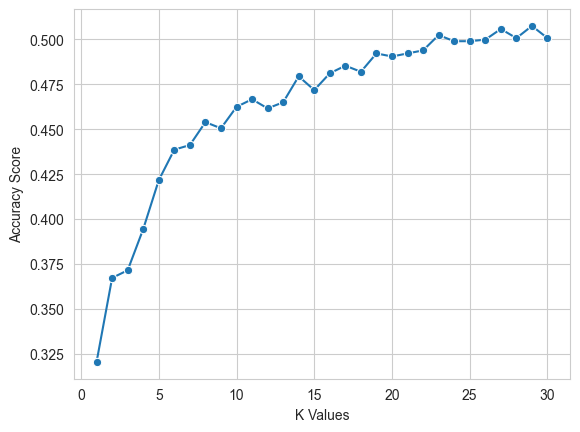

In [128]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [129]:
best_index = np.argmax(scores)
best_k = k_values[best_index]
print("Best K:", best_k)

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

Best K: 29


KNeighborsClassifier(n_neighbors=29)

In [130]:
from sklearn.metrics import precision_score, recall_score

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6059322033898306
Precision: 0.6115051584377302
Recall: 0.6059322033898306


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [131]:
# Classification RFC
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [132]:
y_pred = rfc.predict(X_test)

In [133]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6228813559322034


In [134]:
k_values = [i for i in range (1,100)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    rfc = RandomForestClassifier(n_estimators=k)
    score = cross_val_score(rfc, X, y, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

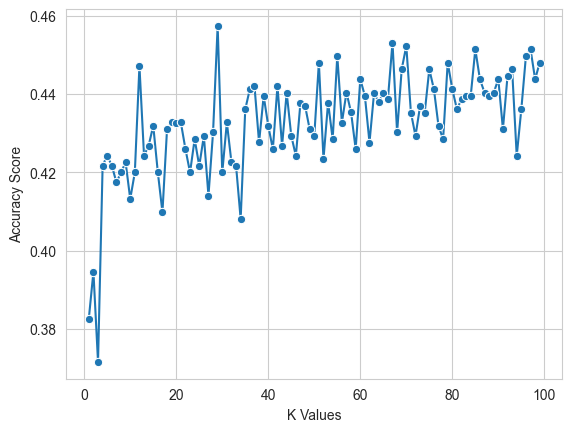

In [135]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [136]:
best_index = np.argmax(scores)
best_k = k_values[best_index]
print("Best K:", best_k)

rfc = RandomForestClassifier(n_estimators=best_k)
rfc.fit(X_train, y_train)

Best K: 29


RandomForestClassifier(n_estimators=29)

In [137]:
from sklearn.metrics import precision_score, recall_score

y_pred = rfc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6101694915254238
Precision: 0.6116267388392469
Recall: 0.6101694915254238


In [138]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Ensemble classifier
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the individual classifiers
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = SVC(probability=True, random_state=1)

# Create the voting classifier
ensemble = VotingClassifier(estimators=[
    ('lr', clf1), ('rf', clf2), ('svc', clf3)],
    voting='soft')

# Fit the model on the training data
ensemble.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = ensemble.score(X_test, y_test)
print("Accuracy of the ensemble model:", accuracy)

Accuracy of the ensemble model: 0.635593220338983


In [139]:
# Regression
# X = df.iloc[:, :-1].values  # features 
# y = df.iloc[:, -1].values   # target 
# 
# z = df.copy()
# z.drop(['mood_of_next_day'], axis=1, inplace=True)
# feature_names = z.columns
# 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# model = RandomForestRegressor()                  # Model loading  
# model.fit(X_train, y_train)                      # Model training or development 
# y_pred = model.predict(X_test)                   # Model prediction 
# model.score(X_test, y_test)
# model1 = RandomForestRegressor(n_estimators=100)
# model1.fit(X_train, y_train)
# feature_imp = pd.Series(data=model1.feature_importances_, index=feature_names)
# feature_imp = feature_imp.sort_values(ascending=False)
# print(feature_imp)
# # Creating a bar plot
# sns.barplot(x=feature_imp, y=feature_imp.index)
# # Add labels to your graph
# plt.xlabel('Feature Importance Score')
# plt.ylabel('Features')
# plt.title("Visualizing Important Features")
# plt.show()

In [140]:
# Regression
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

sliding_window_data_final_regression = sliding_window_data_final.copy()
sliding_window_data_final_regression.head()

,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat_total,appCat.builtin,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,mood_of_next_day
0,1,6.466667,0.333333,0.500000,0.171224,30894.900001,9.0,1.0,31108.660,5156.893,...,114.023,0.0,172.206,410.717,5848.971,952.750,0.000,746.461,30.386,6.00
1,1,6.400000,0.533333,0.433333,0.152861,27963.344002,13.0,1.0,29237.289,2884.631,...,98.585,0.0,3.010,237.524,4564.097,457.110,0.000,326.439,30.386,6.75
2,1,6.516667,0.500000,0.433333,0.106692,43296.538001,10.0,1.0,36713.026,3185.970,...,120.563,0.0,3.010,318.200,6043.936,419.805,235.223,431.711,30.386,6.60
3,1,6.450000,0.366667,0.366667,0.092881,52946.507000,10.0,1.0,44859.560,3067.221,...,129.491,0.0,3.010,342.875,9735.156,419.805,235.223,434.990,0.000,7.00
4,1,6.783333,0.166667,0.633333,0.119731,55341.305999,2.0,2.0,40069.271,3429.592,...,137.604,0.0,182.451,334.849,7446.911,47.314,235.223,435.287,0.000,6.40


In [153]:
sliding_window_data_final_regression.drop('id', axis=1, inplace=True)

KeyError: "['id'] not found in axis"

In [154]:
# Split the data into features (X) and target (y)
X = sliding_window_data_final_regression.drop('mood_of_next_day', axis=1)
y = sliding_window_data_final_regression['mood_of_next_day']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [155]:
# Maybe the following is not necessary for regression # TODO: CHECK
# Scale the features using StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [156]:
# Training regressors
reg1 = GradientBoostingRegressor(random_state=42)
reg2 = RandomForestRegressor(random_state=42)
reg3 = LinearRegression()

reg1.fit(X, y)
reg2.fit(X, y)
reg3.fit(X, y)


ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(X, y)

In [157]:
xt = X[:20]

pred1 = reg1.predict(xt)
pred2 = reg2.predict(xt)
pred3 = reg3.predict(xt)
pred4 = ereg.predict(xt)


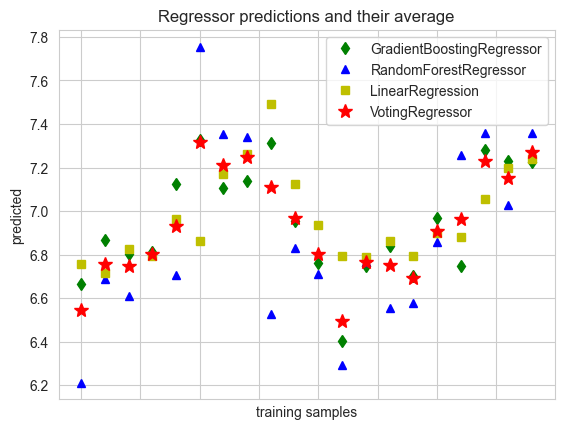

In [158]:
plt.figure()
plt.plot(pred1, "gd", label="GradientBoostingRegressor")
plt.plot(pred2, "b^", label="RandomForestRegressor")
plt.plot(pred3, "ys", label="LinearRegression")
plt.plot(pred4, "r*", ms=10, label="VotingRegressor")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()

In [159]:
from sklearn.metrics import mean_absolute_error, r2_score

# Model evaluation
# Make predictions on the testing data
pred = ereg.predict(X_test)
 
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, pred)
 
# Calculate R-squared (R2) score
r2 = r2_score(y_test, pred)
 
# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared (R2) Score: {r2:.2f}')

Mean Absolute Error (MAE): 0.30
R-squared (R2) Score: 0.64
